In [2]:
### start with the MCMC process, then I'll add in the cosmo part later

In [80]:
conda list

# packages in environment at /global/homes/e/erinbari/.conda/envs/clmmenv:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                 conda_forge    conda-forge
_openmp_mutex             4.5                       2_gnu    conda-forge
alabaster                 0.7.12                   pypi_0    pypi
argon2-cffi               21.3.0                   pypi_0    pypi
argon2-cffi-bindings      21.2.0                   pypi_0    pypi
arviz                     0.12.1             pyhd8ed1ab_1    conda-forge
astropy                   5.1                      pypi_0    pypi
asttokens                 2.0.5              pyhd3eb1b0_0  
attrs                     21.4.0                   pypi_0    pypi
babel                     2.10.3                   pypi_0    pypi
backcall                  0.2.0              pyhd3eb1b0_0  
beautifulsoup4            4.11.1                   pypi_0    pypi
binutils_impl_linux-64    2.36.1               h193b22a

In [4]:
# emcee, chainconsumer, and corner already installed

In [82]:
import numpy as np
import emcee
import matplotlib.pyplot as plt
from chainconsumer import ChainConsumer
import corner
from tqdm import tqdm

In [3]:
# plot settings
import matplotlib as mpl

fontsize = 18
rcparams = {}
rcparams['figure.figsize'] = (10, 6)
rcparams['axes.labelsize'] = fontsize
rcparams['legend.fontsize'] = fontsize-4
rcparams['axes.titlesize'] = fontsize
rcparams['axes.linewidth'] = 2
rcparams['axes.grid'] = True
for axis in ['x', 'y']:
    rcparams['%stick.labelsize' % axis] = fontsize-2
    rcparams['%stick.direction' % axis] = 'in'
    rcparams['%stick.major.size' % axis] = 5.5
    rcparams['%stick.minor.size' % axis] =  3.5
    rcparams['%stick.major.width' % axis] = 2
    rcparams['%stick.minor.width' % axis] = 1.5
rcparams['xtick.top'] = True
rcparams['ytick.right'] = True

# set up the plotting params
for key in rcparams: mpl.rcParams[key] = rcparams[key]

In [4]:
# NOW GENERATE THE MOCK DATA!!!!!

In [5]:
def install_clmm_pipeline(upgrade=False):
    import sys
    try:
        import clmm
        import cluster_toolkit
        installed = True
    except ImportError:
        installed = False
    if not upgrade:
        print('clmm is already installed and upgrade is False')
    else:
        !{sys.executable} -m pip install --user --upgrade git+https://github.com/tmcclintock/cluster_toolkit.git
        !{sys.executable} -m pip install --user --upgrade git+https://github.com/LSSTDESC/CLMM
install_clmm_pipeline(upgrade=True)

  Cloning https://github.com/tmcclintock/cluster_toolkit.git to /tmp/pip-req-build-iozpaf0o
  Running command git clone --filter=blob:none --quiet https://github.com/tmcclintock/cluster_toolkit.git /tmp/pip-req-build-iozpaf0o
  Resolved https://github.com/tmcclintock/cluster_toolkit.git to commit 7bbc4264012e6f1e9344c295e841bbcdba9bdb6a
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [23 lines of output]
      ln: invalid option -- 'h'
      Try 'ln --help' for more information.
      Traceback (most recent call last):
        File "/tmp/pip-req-build-iozpaf0o/setup.py", line 11, in <module>
          cflags = subprocess.check_output(['gsl-config', '--cflags'], universal_newlines=True).split()
        File "/global/homes/e/erinbari/.conda/envs/clmmenv/lib/python3.10/subprocess.py", line 420, in check_output
          return run(*popenargs, stdout=PIPE, timeout=timeout, check

In [6]:
import clmm
import clmm.dataops as da
import clmm.galaxycluster as gc
import clmm.theory as theory
from clmm import Cosmology

In [88]:
clmm.__version__

'1.3.4'

In [8]:
from clmm.support import mock_data as mock

In [9]:
np.random.seed(72)

In [10]:
mock_cosmo = Cosmology(H0 = 70.0, Omega_dm0 = 0.27 - 0.045, Omega_b0 = 0.045, Omega_k0 = 0.0)

In [11]:
### define a mock galaxy cluster:
cosmo = mock_cosmo
cluster_id = "cluster_x"
cluster_m = 1.e15 # M200,m [Msun]
cluster_z = 0.3
src_z = 0.8
concentration = 4
ngals = 10000
cluster_ra = 20.0
cluster_dec = 30.0

In [12]:
ideal_data = mock.generate_galaxy_catalog(cluster_m, cluster_z, concentration,
                                          cosmo, src_z, ngals=ngals, cluster_ra=cluster_ra, cluster_dec=cluster_dec)

In [13]:
gc_object = clmm.GalaxyCluster(cluster_id, cluster_ra, cluster_dec,
                               cluster_z, ideal_data)

In [14]:
gc_object.save('mock_mcmc.pkl')

In [15]:
cl = clmm.GalaxyCluster.load('mock_mcmc.pkl')
print("Cluster info = ID:", cl.unique_id, "; ra:", cl.ra, "; dec:", cl.dec,
      "; z_l :", cl.z)
print("The number of source galaxies is :", len(cl.galcat))

ra_l = cl.ra
dec_l = cl.dec
z = cl.z
e1 = cl.galcat['e1']
e2 = cl.galcat['e2']
ra_s = cl.galcat['ra']
dec_s = cl.galcat['dec']
z_s = cl.galcat['z']

Cluster info = ID: cluster_x ; ra: 20.0 ; dec: 30.0 ; z_l : 0.3
The number of source galaxies is : 10000


/tmp/ipykernel_65332/3372700394.py:8: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(hb)


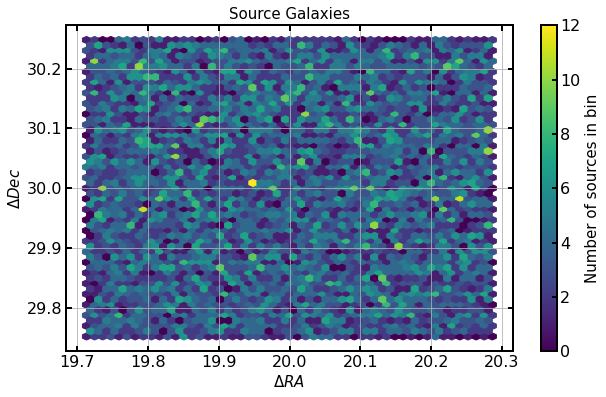

In [16]:
# then visualize distribution of galaxies on sky!

fsize = 15

fig = plt.figure(figsize=(10, 6))
hb = fig.gca().hexbin(ra_s, dec_s, gridsize=50)

cb = fig.colorbar(hb)
cb.set_label('Number of sources in bin', fontsize=fsize)

plt.gca().set_xlabel(r'$\Delta RA$', fontsize=fsize)
plt.gca().set_ylabel(r'$\Delta Dec$', fontsize=fsize)
plt.gca().set_title('Source Galaxies', fontsize=fsize)

plt.show()

In [17]:
# computing shear:

# clmm.dataops.compute_tangential_and_cross_components calculates the tangential and cross shears
# for each source galaxy in the cluster.

theta, g_t, g_x = da.compute_tangential_and_cross_components(ra_l, dec_l, ra_s, dec_s, e1, e2)

Text(0.5, 0, 'angular distance [rad]')

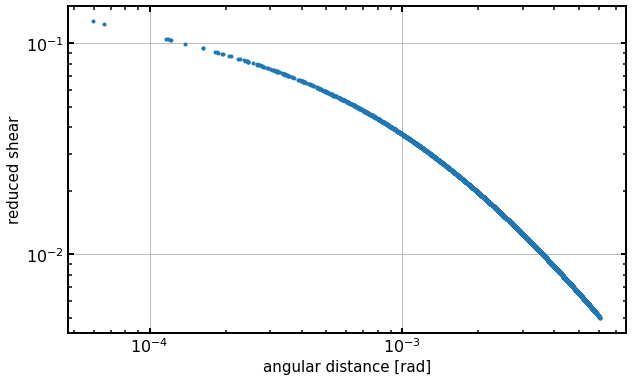

In [18]:
# visualize shear at each location:

fig = plt.figure(figsize=(10, 6))

fig.gca().loglog(theta, g_t, '.')
plt.ylabel("reduced shear", fontsize=fsize)
plt.xlabel("angular distance [rad]", fontsize=fsize)

In [60]:
# radially binning the data

### going to compare results under 2 different binning def's

# *** Note binning would cause fitted mass to be slightly larger than input 
# mass. The reason is that g(r), the tangential reduced shear along cluster 
# radius, is a convex function -- the function value after binning would be
# larger, but the bias becomes smaller as bin number increases.


bin_edges = da.make_bins(0.01, 3.7, 50)

In [61]:
# clmm.dataops.make_radial_profile evaluates the average shear of the galaxy
# catalog in bins of radius.

res = da.make_radial_profile(
    [g_t, g_x, z_s], theta, "radians", "Mpc", bins=bin_edges, cosmo=cosmo, z_lens=z, include_empty_bins=False)


In [62]:
res_with_empty = da.make_radial_profile(
    [g_t, g_x, z_s], theta, "radians", "Mpc", bins=1000, cosmo=cosmo, z_lens=z, include_empty_bins=True)
# this is the default behavior
res_without_empty = da.make_radial_profile(
    [g_t, g_x, z_s], theta, "radians", "Mpc", bins=1000, cosmo=cosmo, z_lens=z, include_empty_bins=False)
res_with_empty['n_src'].size, res_without_empty['n_src'].size

(1000, 899)

In [63]:
gt_profile = res['p_0']
r = res['radius']
z = res['p_2']

Text(0, 0.5, '$g_t$')

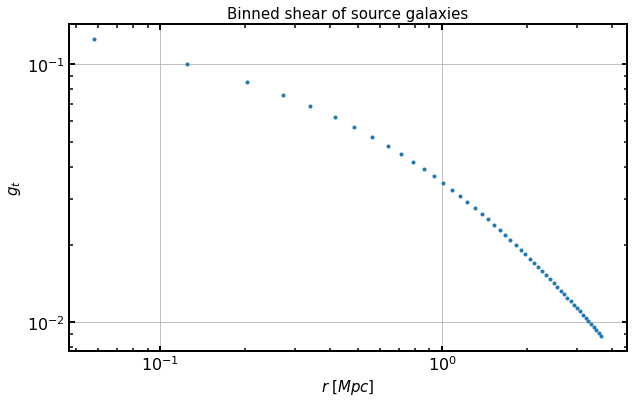

In [64]:
# visualize radially-binned shear

fig = plt.figure(figsize=(10, 6))
fig.gca().loglog(r1, gt_profile, '.', label='50 bins')
plt.gca().set_title(r'Binned shear of source galaxies', fontsize=fsize)
plt.gca().set_xlabel(r'$r\;[Mpc]$', fontsize=fsize)
plt.gca().set_ylabel(r'$g_t$', fontsize=fsize)

In [65]:
# can also use make_radial_profile directly! on a clmm.GalaxyCluster object

cl.compute_tangential_and_cross_components() # You need to add the shear components first
cl.make_radial_profile("Mpc", bins=1000, cosmo=cosmo, include_empty_bins=False)
pass

/global/homes/e/erinbari/.local/lib/python3.10/site-packages/clmm/galaxycluster.py:520: UserWarning: overwriting profile table.
  warnings.warn(f'overwriting {table_name} table.')


In [66]:
for n in cl.profile.colnames: cl.profile[n].format = "%6.3e"
cl.profile.pprint(max_width=-1)

radius_min   radius  radius_max     gt      gt_err      gx       gx_err      z       z_err     n_src  
---------- --------- ---------- --------- --------- ---------- --------- --------- --------- ---------
 1.054e-01 1.081e-01  1.110e-01 1.045e-01 1.933e-04 -4.857e-17 0.000e+00 8.000e-01 0.000e+00 2.000e+00
 1.110e-01 1.118e-01  1.165e-01 1.034e-01 1.777e-05 -2.776e-17 1.963e-17 8.000e-01 0.000e+00 2.000e+00
 1.667e-01 1.704e-01  1.723e-01 9.052e-02 2.053e-04 -2.776e-17 1.179e-17 8.000e-01 0.000e+00 3.000e+00
 1.779e-01 1.800e-01  1.835e-01 8.884e-02 9.369e-05 -4.337e-17 1.227e-18 8.000e-01 0.000e+00 2.000e+00
 2.058e-01 2.089e-01  2.113e-01 8.424e-02 1.262e-04 -1.908e-17 1.349e-17 8.000e-01 0.000e+00 2.000e+00
 2.169e-01 2.196e-01  2.225e-01 8.270e-02 2.879e-05 -1.735e-17 1.717e-17 8.000e-01 0.000e+00 2.000e+00
 2.225e-01 2.260e-01  2.281e-01 8.180e-02 5.956e-05 -3.782e-17 7.601e-19 8.000e-01       nan 5.000e+00
 2.448e-01 2.455e-01  2.504e-01 7.921e-02 2.891e-05 -3.773e-17 3.067e-19 

In [67]:
## once cosmology is chosen! --> choose halo model

# choose halo model: 
### make sure passing mass as a float to clmm

def nfw_to_shear_profile(logm, profile_info):
    r, gt_profile, z_src_rbin = profile_info
    m = float(10.**logm)
    gt_model = clmm.compute_reduced_tangential_shear(
        r, m, concentration, cluster_z, z_src_rbin, cosmo,
        delta_mdef=200, halo_profile_model='nfw')
    return np.sum((gt_model - gt_profile)**2)

In [68]:
###NOW MCMC!!

In [69]:
nfw_to_shear_profile(15,[cl.profile['radius'], cl.profile['gt'], cl.profile['z']])

9.854242498297664e-12

In [70]:
clrad = cl.profile['radius']
clgt = cl.profile['gt']
clz = cl.profile['z']

In [71]:
%%time

chisq = []

for i in range(9,25):
    chisq.append(nfw_to_shear_profile(i,[clrad, clgt, clz]))

    ### to save time, set profile info one time instead of re-calling

CPU times: user 63.4 ms, sys: 4 ms, total: 67.4 ms
Wall time: 65.8 ms


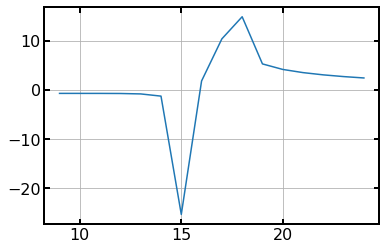

In [72]:
plt.plot(range(9,25),np.log(chisq))

In [73]:
## add in the mass-concentration relationship!

from pyccl.halos.concentration import Concentration as conc

from pyccl.halos.massdef import MassDef200c as m200c

In [74]:
### m = fit mass (m200c); c = concentration (c200c)

In [75]:
r, gt_profile, z_src_rbin = cl.profile['radius'], cl.profile['gt'], cl.profile['z']

In [89]:
def emcee_logprior(params):
    logm = params
    if not 14 < logm < 15.57:
        return -np.inf
    return 0.0

### log mass MUST BE between 14 and 15.57 --> mass must be between 1.e14 and ~3.e15

def emcee_loglike(logm):
    m = float(10.*logm)
    gt_model = clmm.compute_reduced_tangential_shear(
        r, m, concentration, cluster_z, z_src_rbin, cosmo,
        delta_mdef=200, halo_profile_model='nfw')
    return np.sum((gt_model - gt_profile)**2)

### r, concentration, cluster_z, z_src_rbin, cosmo all known / fully-established perfectly

def emcee_logprob(params):
    lp = emcee_logprior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + emcee_loglike(params)

In [93]:
# starting points for the chains
np.random.seed(9281)

nwalkers = 100
npar = 1

starts = np.array([14.5])
starts = starts + 0.1 * np.random.randn(nwalkers, npar)

In [94]:
nsteps_burn, nsteps_per_chain = 500, 2000

# set up the sampler
sampler = emcee.EnsembleSampler(nwalkers, npar, emcee_logprob)
# burn-in
print('## burning in ... ')
pos, prob, stat = sampler.run_mcmc(starts, nsteps_burn, progress=True)
# now reset the sampler
sampler.reset()
# run the full chain now
print('## running the full chain ... ')
sampler.run_mcmc(pos, nsteps_per_chain, progress=True);

## burning in ... 


## running the full chain ... 


truths = [15.0]


<Figure size 432x288 with 0 Axes>

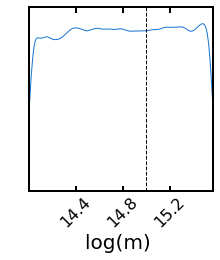

In [95]:
truths = [15.0]
param_labels = ['log(m)']

emcee_samples = sampler.get_chain(flat=True)

print(f'truths = {truths}')
plt.clf()
# set up the object
c = ChainConsumer()
# add chain
c.add_chain(emcee_samples, parameters=param_labels)
c.configure(statistics='max', summary=True,
            label_font_size=20, tick_font_size=16,
            usetex=False, serif=False,
            #max_ticks=5, kde=True
            #sigmas=[0,1,2,3,4,5]
            )
fig = c.plotter.plot(truth=truths,
                     #extents=[(-10, 10), (-10, 10), (-10, 10)],
                     parameters=param_labels,
                     figsize=(3*npar, 3*npar))
ax_list = fig.axes
for ax in ax_list: ax.grid(False)

plt.show();

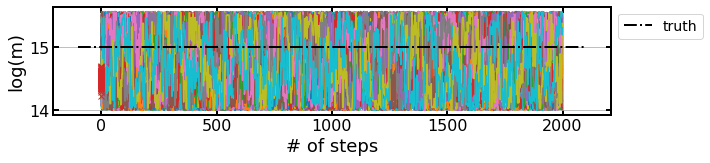

In [96]:
chain = sampler.get_chain()

fig, axes = plt.subplots(npar, 1)
plt.subplots_adjust(wspace=0.2, hspace=0.3)

for i in range(npar):
    ax = axes
    # plot the chain
    ax.plot(chain[:, :, i])
    xmax = len(chain[:, i])
    # truths
    ax.plot([0-100, xmax+100], [ truths[i], truths[i] ], 'k-.', lw=2, label='truth' )
    # starts
    ax.plot([0], [ starts[:, i] ], 'x', color='#d62728' )
    
    ax.set_ylabel(r'%s' % param_labels[i])

axes.legend(bbox_to_anchor=(1, 1))
axes.set_xlabel('# of steps')

fig.set_size_inches(10, 6*npar/3)

<Figure size 432x288 with 0 Axes>

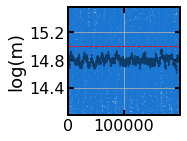

In [97]:
plt.clf()
c.configure_truth(**{'color': 'red'}) #, 'linewidth': '2'})
fig = c.plotter.plot_walks(convolve=100, truth=truths)
fig.set_size_inches(2*npar, 2*npar)
plt.show()

<Figure size 432x288 with 0 Axes>

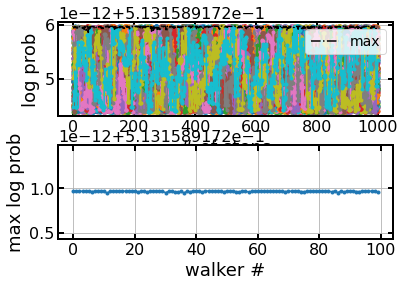

In [86]:
plt.clf()
fig, axes = plt.subplots(2, 1)
plt.subplots_adjust(wspace=0.2, hspace=0.3)

ax = axes[0]
ax.plot(sampler.get_log_prob(), '.-')
ax.plot(np.max( sampler.get_log_prob(), axis=1), 'k-.', label='max')
ax.legend()
ax.set_xlabel('# of steps')
ax.set_ylabel('log prob')
#ax.set_yscale('log')

ax = axes[1]
ax.plot(np.max( sampler.get_log_prob(), axis=0), '.-')
ax.set_xlabel('walker #')
ax.set_ylabel('max log prob')

plt.show()

In [87]:
x0 = np.linspace(-6, 6, 100)
lines = emcee_samples[:, 0] * x0[:, None] + emcee_samples[:, 1]
q = np.percentile(lines, [16, 50, 84], axis=1)
plt.fill_between(x0, q[0], q[2], color="C0", alpha=0.3)
plt.plot(x0, q[1], color="C0")
plt.xlim(-6, 6)

plt.plot(x, y, ".k")
plt.xlabel("x")
plt.ylabel("y");

IndexError: index 1 is out of bounds for axis 1 with size 1